In [1]:
from qiskit import QuantumCircuit
import numpy as np
import matplotlib.pyplot as plt
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

In [2]:
def prepare_input_state(b, num_ancilla=3):

    # Create a quantum circuit
    qc = QuantumCircuit(num_ancilla + 1, num_ancilla) # 1 qubit for b

    # Initialize the quantum state based on b
    qc.initialize([b[0], b[1]], num_ancilla, normalize=True)

    return qc

# Define the vector b
b = np.array([1, 0])

# Define the number of ancilla qubits
num_ancilla = 3

qc = prepare_input_state(b, num_ancilla=num_ancilla)
qc.draw()

q_0: ───────────────────
                        
q_1: ───────────────────
                        
q_2: ───────────────────
     ┌─────────────────┐
q_3: ┤ Initialize(1,0) ├
     └─────────────────┘
c: 3/═══════════════════

In [3]:
from scipy.linalg import expm
from scipy.linalg import ishermitian

def hermitian_to_unitary(A):
    # Check if A is hermitian
    if not ishermitian(A):
        raise ValueError("Matrix A must be Hermitian.")

    # Compute the unitary operator U = exp(i*A*t) out of hermitian matrix
    t = 1/np.pi  # Scaling factor to ensure phases are within [0,1) and distinct
    U = expm(1j * A * t)

    # Verify that U is unitary
    if not np.allclose(U.conj().T @ U, np.eye(len(A))):
        raise ValueError("Matrix U is not unitary.")

    return U

# Define the matrix A
A = np.array([[2, -1],
              [-1, 3]])


U = hermitian_to_unitary(A)
print('Unitary Matrix U = \n', U)

Unitary Matrix U = 
 [[0.76720251+0.5606113j 0.22263263-0.2180596j]
 [0.22263263-0.2180596j 0.54456989+0.7786709j]]


In [4]:
from qiskit.circuit.library import QFT
from qiskit.circuit.library import UnitaryGate

def quantum_phase_estimation(A, b, num_ancilla=3):

    # Ensure the input is a 2D matrix of size 2x2
    if A.shape != (2, 2):
        raise ValueError("The input matrix must be 2x2.")

    # Convert the matrix into a unitary
    U = hermitian_to_unitary(A)

    # Create a quantum circuit prepared in initial state based on b
    qc = prepare_input_state(b, num_ancilla=num_ancilla)

    # Step 1: Apply Hadamard gates to the ancilla qubits
    qc.h(range(num_ancilla))

    # Step 2: Apply controlled unitary operations
    for qubit in range(num_ancilla):
        exponent = 2 ** qubit
        controlled_unitary = UnitaryGate(np.linalg.matrix_power(U, exponent)).control()  # Controlled U^(2^exponent)
        qc.append(controlled_unitary, [qubit, num_ancilla])

    # Step 3: Apply Inverse Quantum Fourier Transform (QFT) to the ancilla qubits
    qc.append(QFT(num_ancilla, inverse=True).to_gate(), range(num_ancilla))

    return qc


# Generate the Quantum Phase Estimation circuit for this matrix
qc = quantum_phase_estimation(A, b, num_ancilla=num_ancilla)
qc.draw()

┌───┐                                        ┌───────┐
q_0: ───────┤ H ├────────────■───────────────────────────┤0      ├
            ├───┤            │                           │       │
q_1: ───────┤ H ├────────────┼──────────■────────────────┤1 IQFT ├
            ├───┤            │          │                │       │
q_2: ───────┤ H ├────────────┼──────────┼──────────■─────┤2      ├
     ┌──────┴───┴──────┐┌────┴────┐┌────┴────┐┌────┴────┐└───────┘
q_3: ┤ Initialize(1,0) ├┤ Unitary ├┤ Unitary ├┤ Unitary ├─────────
     └─────────────────┘└─────────┘└─────────┘└─────────┘         
c: 3/═════════════════════════════════════════════════════════════

Measurement results: {'010': 136, '001': 505, '000': 255, '110': 20, '111': 38, '101': 16, '100': 19, '011': 35}


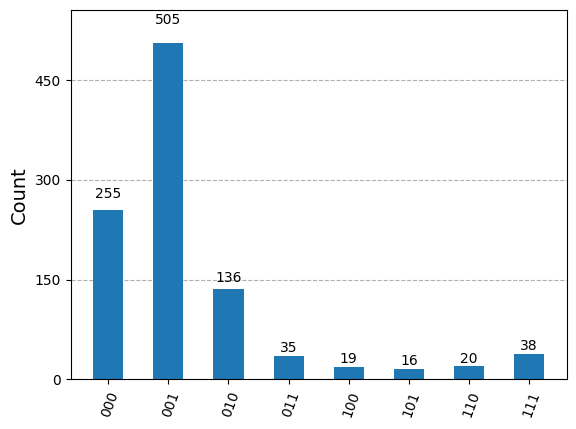

In [5]:
# Optional: perform measurement to find eigenvalues

# Measure the ancilla qubits to extract phase information
qc.measure(range(num_ancilla), range(num_ancilla))

# Simulate the circuit using the Aer simulator
simulator = AerSimulator()
job = simulator.run(transpile(qc, simulator), shots=1024)
result = job.result()

# Print the measurement results
counts = result.get_counts(qc)
print(f"Measurement results: {counts}")

# Plot the histogram
plot_histogram(counts)

In [6]:
#Convert measured outcomes to phases and then to eigenvalues
for measurement, count in counts.items():
    # Convert binary measurement to phase
    phase = sum(int(bit) * (1 / (2 ** (index + 1))) for index, bit in enumerate(reversed(measurement)))
    eigenvalue_estimate = 2 * np.pi * phase  # Scale to [0, 2π]

    # Since U = e^(i*λ), we can recover λ
    eigenvalue = np.angle(np.exp(1j * eigenvalue_estimate))

    if count > 100:
        print(f"Measured: {measurement}, Phase: {phase:.3f}, Eigenvalue estimate: {eigenvalue:.3f}")


Measured: 010, Phase: 0.250, Eigenvalue estimate: 1.571
Measured: 001, Phase: 0.500, Eigenvalue estimate: 3.142
Measured: 000, Phase: 0.000, Eigenvalue estimate: 0.000


In [7]:
#########################################################################
#eigenvalues = [3.142, 1.571] # should be extracted out of the measurement result
eigenvalues = [1.38196601, 3.61803399]
#########################################################################

def controlled_rotations(qc, eigenvalues, num_ancilla):
    target_qubit = num_ancilla
    for idx, eigenvalue in enumerate(eigenvalues):
        if eigenvalue != 0:
            angle = 2 * np.pi / eigenvalue  # Convert eigenvalue to angle for rotation
            qc.crz(angle, idx, target_qubit)  # Apply controlled rotation (controlled RZ)
    return qc


qc = controlled_rotations(qc, eigenvalues, num_ancilla)
qc.draw()


┌───┐                                        ┌───────┐┌─┐      »
q_0: ───────┤ H ├────────────■───────────────────────────┤0      ├┤M├──────»
            ├───┤            │                           │       │└╥┘┌─┐   »
q_1: ───────┤ H ├────────────┼──────────■────────────────┤1 IQFT ├─╫─┤M├───»
            ├───┤            │          │                │       │ ║ └╥┘┌─┐»
q_2: ───────┤ H ├────────────┼──────────┼──────────■─────┤2      ├─╫──╫─┤M├»
     ┌──────┴───┴──────┐┌────┴────┐┌────┴────┐┌────┴────┐└───────┘ ║  ║ └╥┘»
q_3: ┤ Initialize(1,0) ├┤ Unitary ├┤ Unitary ├┤ Unitary ├──────────╫──╫──╫─»
     └─────────────────┘└─────────┘└─────────┘└─────────┘          ║  ║  ║ »
c: 3/══════════════════════════════════════════════════════════════╩══╩══╩═»
                                                                   0  1  2 »
«                                 
«q_0: ──────■─────────────────────
«           │                     
«q_1: ──────┼─────────────■───────
«           │             │       
«q_2: ──────┼─────────────┼───────
«     ┌─────┴──────┐┌─────┴──────┐
«q_3: ┤ Rz(4.5466) ├┤ Rz(1.7366) ├
«     └────────────┘└────────────┘
«c: 3/════════════════════════════
«

In [8]:
def inverse_quantum_phase_estimation(A, num_ancilla=3):

    # Step 1: Apply Quantum Fourier Transform (QFT) to the ancilla qubits
    qc.append(QFT(num_ancilla, inverse=False).to_gate(), range(num_ancilla))

    # Step 2: Apply inverse of controlled unitary operations
    U = hermitian_to_unitary(A)
    for qubit in reversed(range(num_ancilla)):
        exponent = 2 ** qubit
        controlled_unitary_dagger = UnitaryGate(np.linalg.matrix_power(U, exponent).conj().T).control()  # Controlled U^(2^exponent) dagger
        qc.append(controlled_unitary_dagger, [qubit, num_ancilla])

    # Step 3: Apply Hadamard gates to the ancilla qubits
    qc.h(range(num_ancilla))

    return qc

qc = inverse_quantum_phase_estimation(A, num_ancilla=num_ancilla)
qc.draw()

┌───┐                                        ┌───────┐┌─┐      »
q_0: ───────┤ H ├────────────■───────────────────────────┤0      ├┤M├──────»
            ├───┤            │                           │       │└╥┘┌─┐   »
q_1: ───────┤ H ├────────────┼──────────■────────────────┤1 IQFT ├─╫─┤M├───»
            ├───┤            │          │                │       │ ║ └╥┘┌─┐»
q_2: ───────┤ H ├────────────┼──────────┼──────────■─────┤2      ├─╫──╫─┤M├»
     ┌──────┴───┴──────┐┌────┴────┐┌────┴────┐┌────┴────┐└───────┘ ║  ║ └╥┘»
q_3: ┤ Initialize(1,0) ├┤ Unitary ├┤ Unitary ├┤ Unitary ├──────────╫──╫──╫─»
     └─────────────────┘└─────────┘└─────────┘└─────────┘          ║  ║  ║ »
c: 3/══════════════════════════════════════════════════════════════╩══╩══╩═»
                                                                   0  1  2 »
«                                 ┌──────┐                           »
«q_0: ──────■─────────────────────┤0     ├───────────────────────────»
«           │                     │      │                      ┌───┐»
«q_1: ──────┼─────────────■───────┤1 QFT ├────────────────■─────┤ H ├»
«           │             │       │      │                │     ├───┤»
«q_2: ──────┼─────────────┼───────┤2     ├─────■──────────┼─────┤ H ├»
«     ┌─────┴──────┐┌─────┴──────┐└──────┘┌────┴────┐┌────┴────┐└───┘»
«q_3: ┤ Rz(4.5466) ├┤ Rz(1.7366) ├────────┤ Unitary ├┤ Unitary ├─────»
«     └────────────┘└────────────┘        └─────────┘└─────────┘     »
«c: 3/═══════════════════════════════════════════════════════════════»
«                                                                    »
«                ┌───┐
«q_0: ─────■─────┤ H ├
«          │     └───┘
«q_1: ─────┼──────────
«          │          
«q_2: ─────┼──────────
«     ┌────┴────┐     
«q_3: ┤ Unitary ├─────
«     └─────────┘     
«c: 3/════════════════
«

In [9]:

# # Measure the ancilla qubits to extract output states
# qc.measure(range(num_ancilla), range(num_ancilla))

# # Simulate the circuit using the Aer simulator
# simulator = AerSimulator()
# job = simulator.run(transpile(qc, simulator), shots=1024)
# result = job.result()
# statevector = result.get_statevector(qc)

# print(statevector)
# # Print the measurement results
# counts = result.get_counts(qc)
# print(f"Measurement results: {counts}")

# # Plot the histogram
# plot_histogram(counts)

In [10]:

from qiskit.quantum_info import partial_trace, Statevector


# Save the statevector and measure ancilla qubits
qc.save_statevector()
qc.measure(range(num_ancilla), range(num_ancilla))

# Simulate the circuit
simulator = AerSimulator()
job = simulator.run(transpile(qc, simulator))
result = job.result()

# Extract the statevector of the full system (data + ancilla qubits)
statevector = result.get_statevector(qc)
print("Full statevector:", statevector)

# Trace out the ancilla qubits to isolate the data qubits
data_qubits_state = partial_trace(statevector, range(num_ancilla))
print("Data qubits state (density matrix):", data_qubits_state)

# Extract the amplitudes from the density matrix
# Diagonal elements represent |alpha_0|^2 and |alpha_1|^2
rho_00 = data_qubits_state.data[0, 0]  # Diagonal element |0><0|
rho_11 = data_qubits_state.data[1, 1]  # Diagonal element |1><1|
rho_01 = data_qubits_state.data[0, 1]  # Off-diagonal element |0><1| (used for phase)

# Compute the amplitudes for |0> and |1> based on the diagonal elements
alpha_0 = np.sqrt(np.real(rho_00))
alpha_1 = np.sqrt(np.real(rho_11))

# Reconstruct the pure statevector (ignoring any phases for now)
statevector_x = np.array([alpha_0, alpha_1])
print("Reconstructed quantum solution (unnormalized):", statevector_x)

# Classical solution (for comparison and normalization)
x_classical = np.linalg.solve(A, b)
print("Classical solution:", x_classical)

# Compute the norms of the quantum and classical solutions
norm_classical = np.linalg.norm(x_classical)
norm_quantum = np.linalg.norm(statevector_x)

# Scale the quantum solution to match the classical solution's norm
scaled_solution = (norm_classical / norm_quantum) * statevector_x

print("Scaled quantum solution vector:", scaled_solution)

# Get the measurement results (counts)
counts = result.get_counts(qc)
print(f"Measurement results: {counts}")


Full statevector: Statevector([-0.16721932+0.47756597j, -0.03768216+0.02524167j,
             -0.07824385+0.052052j  ,  0.01059262-0.03276352j,
             -0.18588543+0.11940047j,  0.02437529-0.07641105j,
              0.05029651-0.15808253j,  0.01416555-0.00741816j,
             -0.07887446-0.4571349j ,  0.11603761+0.02013266j,
              0.24019299+0.04155678j,  0.00480811+0.03319168j,
              0.56176706+0.09580577j,  0.010988  +0.0780937j ,
              0.02264185+0.16183858j, -0.03931284-0.00614837j],
            dims=(2, 2, 2, 2))
Data qubits state (density matrix): DensityMatrix([[ 0.35112399+0.j        , -0.35029493-0.02437644j],
               [-0.35029493+0.02437644j,  0.64887601+0.j        ]],
              dims=(2,))
Reconstructed quantum solution (unnormalized): [0.59255716 0.8055284 ]
Classical solution: [0.6 0.2]
Scaled quantum solution vector: [0.37476606 0.50946089]
Measurement results: {'000': 354, '100': 335, '110': 114, '001': 32, '010': 93, '111': 34, '0

Success probability: 0.4961


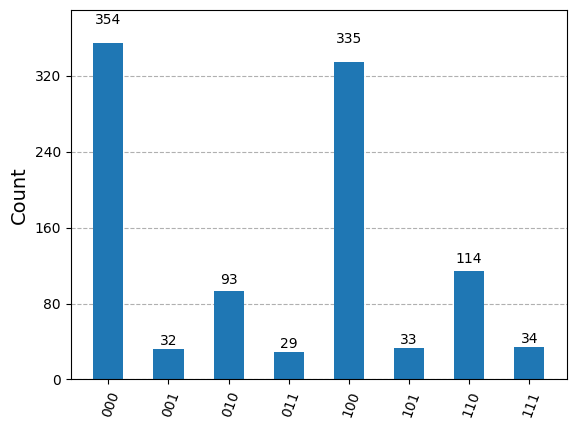

In [11]:
# Calculate the total number of shots (all counts)
total_shots = sum(counts.values())

# Calculate the number of successful shots (where the first qubit is 0)
success_shots = sum(count for outcome, count in counts.items() if outcome[0] == '0')

# Calculate success probability
success_probability = success_shots / total_shots

# Print the success probability
print(f"Success probability: {success_probability:.4f}")

# Plot the histogram of the measurement results
plot_histogram(counts)

In [12]:
# Compute eigenvalues and eigenvectors of A
eigenvalues, eigenvectors = np.linalg.eigh(A)
print("Eigenvalues of A:", eigenvalues)
print("Eigenvectors of A:\n", eigenvectors)

# Calculate the min and max eigenvalues of the matrix A
min_eigenvalue = np.min(eigenvalues)
max_eigenvalue = np.max(eigenvalues)
print("Max eigenvalue of A:", max_eigenvalue)
print("Min eigenvalue of A:", min_eigenvalue)

# Solve for x in the equation Ax = b
x = np.linalg.solve(A, b)
print("Solution x = \n", x)


Eigenvalues of A: [1.38196601 3.61803399]
Eigenvectors of A:
 [[-0.85065081 -0.52573111]
 [-0.52573111  0.85065081]]
Max eigenvalue of A: 3.618033988749895
Min eigenvalue of A: 1.381966011250105
Solution x = 
 [0.6 0.2]


In [13]:
from qiskit import QuantumCircuit
import numpy as np
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import DensityMatrix, partial_trace, Statevector

## OTHER TEST

In [14]:
# Put it all in one function to plot the result based in the max number of ancillae qubits

def HHL(A, b, max_num_ancillae=3):

    # Check if A is hermitian, otherwise build hermitian matrix H out of A
    if ishermitian(A):
        H = A
        #print("A is hermitian.")
    else:
        H = np.vstack([np.hstack([np.zeros((2,2)), np.conj(A).T]), np.hstack([A, np.zeros((2,2))])])
        print("A is not hermitian.")
        print('Hermitian Matrix H = \n', H)

    # Compute eigenvalues and eigenvectors of H
    eigenvalues, eigenvectors = np.linalg.eigh(H)
    min_eigenvalue = np.min(eigenvalues)
    max_eigenvalue = np.max(eigenvalues)

    # Compute the unitary operator U = exp(i*H*t) out of hermitian matrix
    t = 1 / (max_eigenvalue * 5) # Scaling factor to ensure phases are within [0,1) and distinct
    U = expm(1j * H * t)
    #print('Unitary Matrix U = \n', U)

    # Verify that U is unitary
    identity = np.eye(len(H))
    if not np.allclose(U.conj().T @ U, identity):
        print("U is not unitary.")

    # Prepare to store the solution vector
    solution_vectors = []

    # Loop over increasing num_ancillae
    for num_ancillae in range(1, max_num_ancillae + 1):

        # Normalize b
        b_normalized = b / np.linalg.norm(b)

        # Initialize the quantum circuit with 1 qubit in |0> state representing the vector b
        qc = QuantumCircuit(num_ancillae + 1, num_ancillae) # 1 qubit for b

        # Initialize the quantum state based on b
        qc.initialize([b_normalized[0], b_normalized[1]], num_ancillae)

        # Apply Hadamard gates to all ancilla qubits
        qc.h(range(num_ancillae))

        # Apply controlled-U operations based on eigenvalues
        for i in range(num_ancillae):
            angle = -2 * np.pi * (eigenvalues[i % len(eigenvalues)] * t)
            qc.crz(angle, i, num_ancillae)  # Controlled rotation based on eigenvalue
        #for qubit in range(num_ancillae):
        #    qc.append(UnitaryGate(U, label="A^2^" + str(qubit)).control(), [qubit, num_ancillae])

        # Apply inverse QFT to ancilla qubits
        qc.append(QFT(num_ancillae, inverse=True).to_gate(), range(num_ancillae))

        # Measure ancilla qubits
        #qc.measure(range(num_ancillae), range(num_ancillae))


        # Save the statevectors
        qc.save_statevector()

        # Run simulator
        job = simulator.run(transpile(qc, simulator))
        result = job.result()

        # Retrieve the statevector
        statevector = result.get_statevector(qc)

        # Extract the relevant part of the statevector
        # For each configuration of the ancilla qubits, the last qubit encodes the solution
        # We need to consider all combinations of ancilla states
        x_solution = np.zeros(2, dtype=complex)

        for i in range(2 ** num_ancillae):
            # Create a binary representation of the ancilla state
            ancilla_state = f"{i:0{num_ancillae}b}"  # Create a binary string of length num_ancillae
            index_0 = int(ancilla_state + '0', 2)  # Last qubit is |0>
            x_solution[0] += statevector[index_0]  # Amplitude for |0> in the last qubit
            index_1 = int(ancilla_state + '1', 2)  # Last qubit is |1>
            x_solution[1] += statevector[index_1]  # Amplitude for |1> in the last qubit


        # Normalize the solution vector
        x_solution /= np.linalg.norm(x_solution)

        # Append the solution vector for this number of ancillae
        solution_vectors.append(x_solution)

    # Display the solution vectors
    for i, sol_vec in enumerate(solution_vectors):
        print(f"Approximated solution for {i+1} ancillae qubits: x = [{sol_vec[0].real:.4f}, {sol_vec[1].real:.4f}]")


    return solution_vectors
